/tmp/ipykernel_82613/1285918456.py:37: RuntimeWarning: invalid value encountered in divide
  hue[mask & (cmax == r)] = (60 * ((g - b) / delta % 6))[mask & (cmax == r)]
/tmp/ipykernel_82613/1285918456.py:38: RuntimeWarning: invalid value encountered in divide
  hue[mask & (cmax == g)] = (60 * ((b - r) / delta + 2))[mask & (cmax == g)]
/tmp/ipykernel_82613/1285918456.py:39: RuntimeWarning: invalid value encountered in divide
  hue[mask & (cmax == b)] = (60 * ((r - g) / delta + 4))[mask & (cmax == b)]


No disc detected.


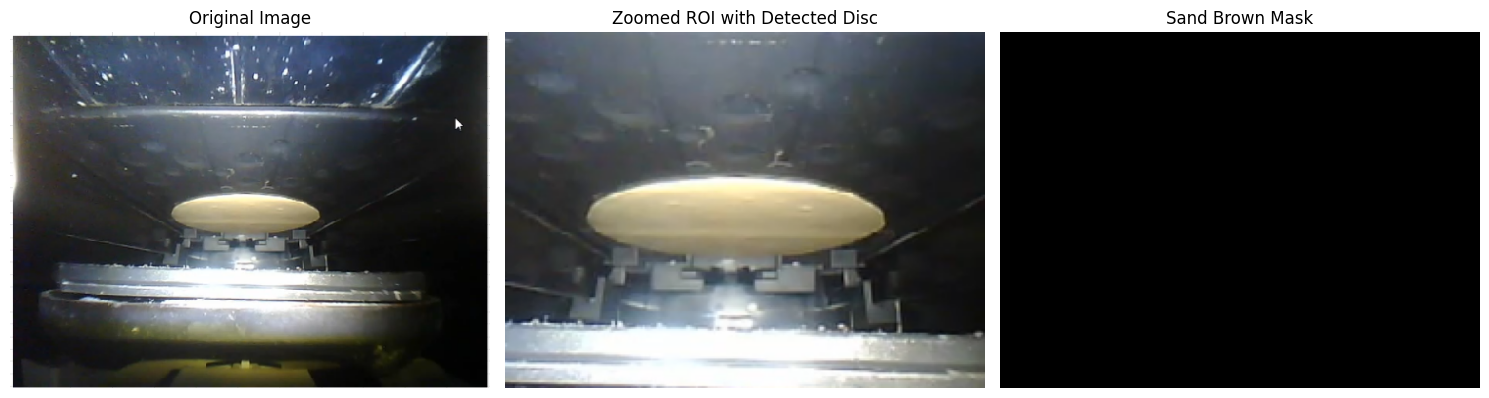

In [7]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the image
#image = Image.open("02 Disc Detection and Centering/800x600/With Load/Disc at pos 100/Trial 1.jpg")
image = Image.open("pos100.jpg")
image_array = np.array(image)
height, width, _ = image_array.shape

# Step 2: Define zoomed ROI (20% more)
roi_scale = 0.5
roi_width = int(width * roi_scale)
roi_height = int(height * roi_scale)
x_offset = (roi_width - width) // 2
y_offset = (roi_height - height) // 2

# Ensure ROI doesn't exceed image bounds
x_start = max(0, -x_offset)
x_end = min(width, width + x_offset)
y_start = max(0, -y_offset)
y_end = min(height, height + y_offset)
roi = image_array[y_start:y_end, x_start:x_end]

# Step 3: Convert to HSV-like values manually
def rgb_to_hsv_manual(image):
    # Normalize RGB values to range [0, 1]
    image = image / 255.0
    r, g, b = image[..., 0], image[..., 1], image[..., 2]
    cmax = np.max(image, axis=-1)
    cmin = np.min(image, axis=-1)
    delta = cmax - cmin

    # Calculate Hue
    hue = np.zeros_like(cmax)
    mask = delta > 0
    hue[mask & (cmax == r)] = (60 * ((g - b) / delta % 6))[mask & (cmax == r)]
    hue[mask & (cmax == g)] = (60 * ((b - r) / delta + 2))[mask & (cmax == g)]
    hue[mask & (cmax == b)] = (60 * ((r - g) / delta + 4))[mask & (cmax == b)]
    hue = hue / 360  # Scale hue to [0, 1]

    # Calculate Saturation
    saturation = np.zeros_like(cmax)
    saturation[cmax > 0] = delta[cmax > 0] / cmax[cmax > 0]

    # Value (Brightness) is the maximum channel
    value = cmax

    return hue, saturation, value

# Convert ROI to HSV
hue, saturation, value = rgb_to_hsv_manual(roi)

# Step 4: Create a mask for sand-brown color
# lower_hue, upper_hue = 0.12, 0.2  # Adjusted for sand-brown range
# lower_saturation, upper_saturation = 0.2, 0.6
# lower_value, upper_value = 0.2, 0.8

lower_hue, upper_hue = 0.12, 0.2  # Broaden the range for Hue
lower_saturation, upper_saturation = 0.2, 0.6  # Broaden the range for Saturation
lower_value, upper_value = 0.2, 0.9  # Broaden the range for Value


mask = (
    (hue >= lower_hue) & (hue <= upper_hue) &
    (saturation >= lower_saturation) & (saturation <= upper_saturation) &
    (value >= lower_value) & (value <= upper_value)
)

# Step 5: Blob detection (largest connected region)
def find_largest_blob(binary_mask):
    visited = np.zeros_like(binary_mask, dtype=bool)
    max_area = 0
    largest_blob_coords = []

    def dfs(x, y):
        stack = [(x, y)]
        blob_coords = []
        while stack:
            cx, cy = stack.pop()
            if not visited[cx, cy] and binary_mask[cx, cy]:
                visited[cx, cy] = True
                blob_coords.append((cx, cy))
                # Add neighbors
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    nx, ny = cx + dx, cy + dy
                    if 0 <= nx < binary_mask.shape[0] and 0 <= ny < binary_mask.shape[1]:
                        stack.append((nx, ny))
        return blob_coords

    for i in range(binary_mask.shape[0]):
        for j in range(binary_mask.shape[1]):
            if binary_mask[i, j] and not visited[i, j]:
                blob = dfs(i, j)
                if len(blob) > max_area:
                    max_area = len(blob)
                    largest_blob_coords = blob

    return largest_blob_coords, max_area

largest_blob, blob_area = find_largest_blob(mask)
brown_pixel_count = np.sum(mask)

# Step 6: Disc detection based on brown-pixel density
brown_pixel_threshold = 0.05  # Adjust this based on expected disc size
total_pixels = mask.shape[0] * mask.shape[1]
brown_pixel_density = brown_pixel_count / total_pixels

is_disc_present = brown_pixel_density > brown_pixel_threshold and blob_area > 0.05 * total_pixels

# Draw bounding box around largest blob if disc is present
if is_disc_present and largest_blob:
    largest_blob = np.array(largest_blob)
    min_y, min_x = np.min(largest_blob, axis=0)
    max_y, max_x = np.max(largest_blob, axis=0)

    # Draw bounding box on ROI
    roi[min_y:max_y, min_x] = [0, 255, 0]  # Vertical line
    roi[min_y:max_y, max_x] = [0, 255, 0]
    roi[min_y, min_x:max_x] = [0, 255, 0]  # Horizontal line
    roi[max_y, min_x:max_x] = [0, 255, 0]

    print(f"Disc detected! Bounding box: Top-left ({min_x}, {min_y}), Bottom-right ({max_x}, {max_y})")
else:
    print("No disc detected.")

# Visualization using Matplotlib
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original Image
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Zoomed ROI with detected disc
axes[1].imshow(roi)
axes[1].set_title("Zoomed ROI with Detected Disc")
axes[1].axis("off")

# Mask of Sand Brown
axes[2].imshow(mask, cmap="gray")
axes[2].set_title("Sand Brown Mask")
axes[2].axis("off")

plt.tight_layout()
plt.show()